### Calculate condition specificity, annotate cluster size

In [169]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import sys

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hypergeom
import random

import matplotlib.cm as cm
import matplotlib.colors as mcolors 

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

pd.set_option('display.max_rows', 100)
sc.set_figure_params(figsize=(20, 4))

In [170]:
datadir = '/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data/CD4i_final'
experiment_name = 'CD4i_final'
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results_corrected.h5ad', backed='r')

In [171]:
de_summary_stats = pd.read_csv('../../../../3_expts/processed_data/CD4i_final/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)

In [172]:
adata_final = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering.h5ad', backed='r')

In [173]:
adata_final

AnnData object with n_obs × n_vars = 3341 × 13959 backed at '../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering.h5ad'
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected', 'hdbscan'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'masked_zscore', 'p_value', 'zscore'

In [174]:
masked_zscore_df = pd.DataFrame(adata_de[adata_de.obs.target_contrast_corrected.isin(adata_final.obs.target_contrast_corrected.unique().tolist())].layers['masked_zscore'],
                                index=adata_de[adata_de.obs.target_contrast_corrected.isin(adata_final.obs.target_contrast_corrected.unique().tolist())].obs_names,
                                columns=adata_de[adata_de.obs.target_contrast_corrected.isin(adata_final.obs.target_contrast_corrected.unique().tolist())].var_names)

In [175]:
X = masked_zscore_df.values
row_means = X.mean(axis=1, keepdims=True)
row_stds = X.std(axis=1, keepdims=True)
Z = (X - row_means) / row_stds
R_unscaled = Z @ Z.T
R = R_unscaled / (X.shape[1])
corr_df_all = pd.DataFrame(R, index=masked_zscore_df.index.tolist(), columns=masked_zscore_df.index.tolist())

In [176]:
corr_df_all.to_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_gene_across_condition_correlation_matrix.csv')

In [7]:
adata_final.obs['hdbscan_corr_rest_over_across_condition'] = 0
adata_final.obs['hdbscan_corr_stim8hr_over_across_condition'] = 0
adata_final.obs['hdbscan_corr_stim48hr_over_across_condition'] = 0
adata_final.obs['cluster_gene_size'] = 0

In [153]:
def corr_enrichment(df):
    corr_across_condition = np.mean(df[df.perturbation_1_condition!=df.perturbation_2_condition].Correlation_Value)
    corr_rest = np.mean(df[(df.perturbation_1_condition=='Rest')&(df.perturbation_2_condition=='Rest')].Correlation_Value)
    corr_stim8hr = np.mean(df[(df.perturbation_1_condition=='Stim8hr')&(df.perturbation_2_condition=='Stim8hr')].Correlation_Value)
    corr_stim48hr = np.mean(df[(df.perturbation_1_condition=='Stim48hr')&(df.perturbation_2_condition=='Stim48hr')].Correlation_Value)
    corr_max = np.max([corr_rest, corr_stim8hr, corr_stim48hr, corr_across_condition])
    #corr_std = df.Correlation_Value.std()
    
    return (corr_rest - corr_across_condition) / corr_max,\
    (corr_stim8hr - corr_across_condition) / corr_max,\
    (corr_stim48hr - corr_across_condition) / corr_max

In [ ]:
# def corr_enrichment(df):
#     corr_across_condition = np.mean(np.arctanh(df[df.perturbation_1_condition!=df.perturbation_2_condition].Correlation_Value))
#     corr_rest = np.mean(np.arctanh(df[(df.perturbation_1_condition=='Rest')&(df.perturbation_2_condition=='Rest')].Correlation_Value))
#     corr_stim8hr = np.mean(np.arctanh(df[(df.perturbation_1_condition=='Stim8hr')&(df.perturbation_2_condition=='Stim8hr')].Correlation_Value))
#     corr_stim48hr = np.mean(np.arctanh(df[(df.perturbation_1_condition=='Stim48hr')&(df.perturbation_2_condition=='Stim48hr')].Correlation_Value))
#     corr_max = np.max([corr_rest, corr_stim8hr, corr_stim48hr, corr_across_condition])

#     return corr_rest - corr_across_condition, corr_stim8hr - corr_across_condition, corr_stim48hr - corr_across_condition
#     #return (corr_rest - corr_across_condition) / corr_max,\
#     #(corr_stim8hr - corr_across_condition) / corr_max,\
#     #(corr_stim48hr - corr_across_condition) / corr_max

In [165]:
cl = 8
gene_id_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
obs_names = adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].obs_names
corr_df = corr_df_all.loc[obs_names,obs_names]

corr_df = corr_df.reset_index()
corr_df = corr_df.rename(columns={'index': 'Index_ID'})
corr_all_long = pd.melt(corr_df, 
                        id_vars=['Index_ID'],
                        var_name='Column_ID',
                        value_name='Correlation_Value'
                       )
corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]

corr_enrichment(corr_all_long)

(0.38020364510671845, 0.5454805520907132, 0.33504734386075236)

In [96]:
np.arctanh(corr_all_long[corr_all_long.perturbation_1_condition!=corr_all_long.perturbation_2_condition].Correlation_Value)

2      0.484216
5      0.487450
8      0.531843
9      0.185849
10     0.403654
         ...   
433    0.402792
435    0.342325
436    0.309767
438    0.352985
439    0.394874
Name: Correlation_Value, Length: 252, dtype: float64

In [23]:
corr_all = pd.DataFrame(adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_bs_list)].layers['masked_zscore'].T,
                       columns=adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_bs_list)].obs_names).corr()
corr_all = corr_all.reset_index()
corr_all = corr_all.rename(columns={'index': 'Index_ID'})
corr_all_long = pd.melt(corr_all, 
                        id_vars=['Index_ID'],
                        var_name='Column_ID',
                        value_name='Correlation_Value'
                       )
corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]

corr_enrichment(corr_all_long)

(-0.23627010600678836, -0.04479724112634772, 0.8440332177644355)

In [166]:
import random
random.seed(42)
num_of_test = 1000
hdbscan_corr_over_across_condition_null = np.zeros([num_of_test,3])
for i in range(num_of_test):
    corr_all_long_for_test = corr_all_long.copy()
    Correlation_Value = corr_all_long_for_test['Correlation_Value'].tolist()
    random.shuffle(Correlation_Value)
    corr_all_long_for_test['Correlation_Value'] = Correlation_Value
    hdbscan_corr_over_across_condition_null[i,:] = corr_enrichment(corr_all_long_for_test)

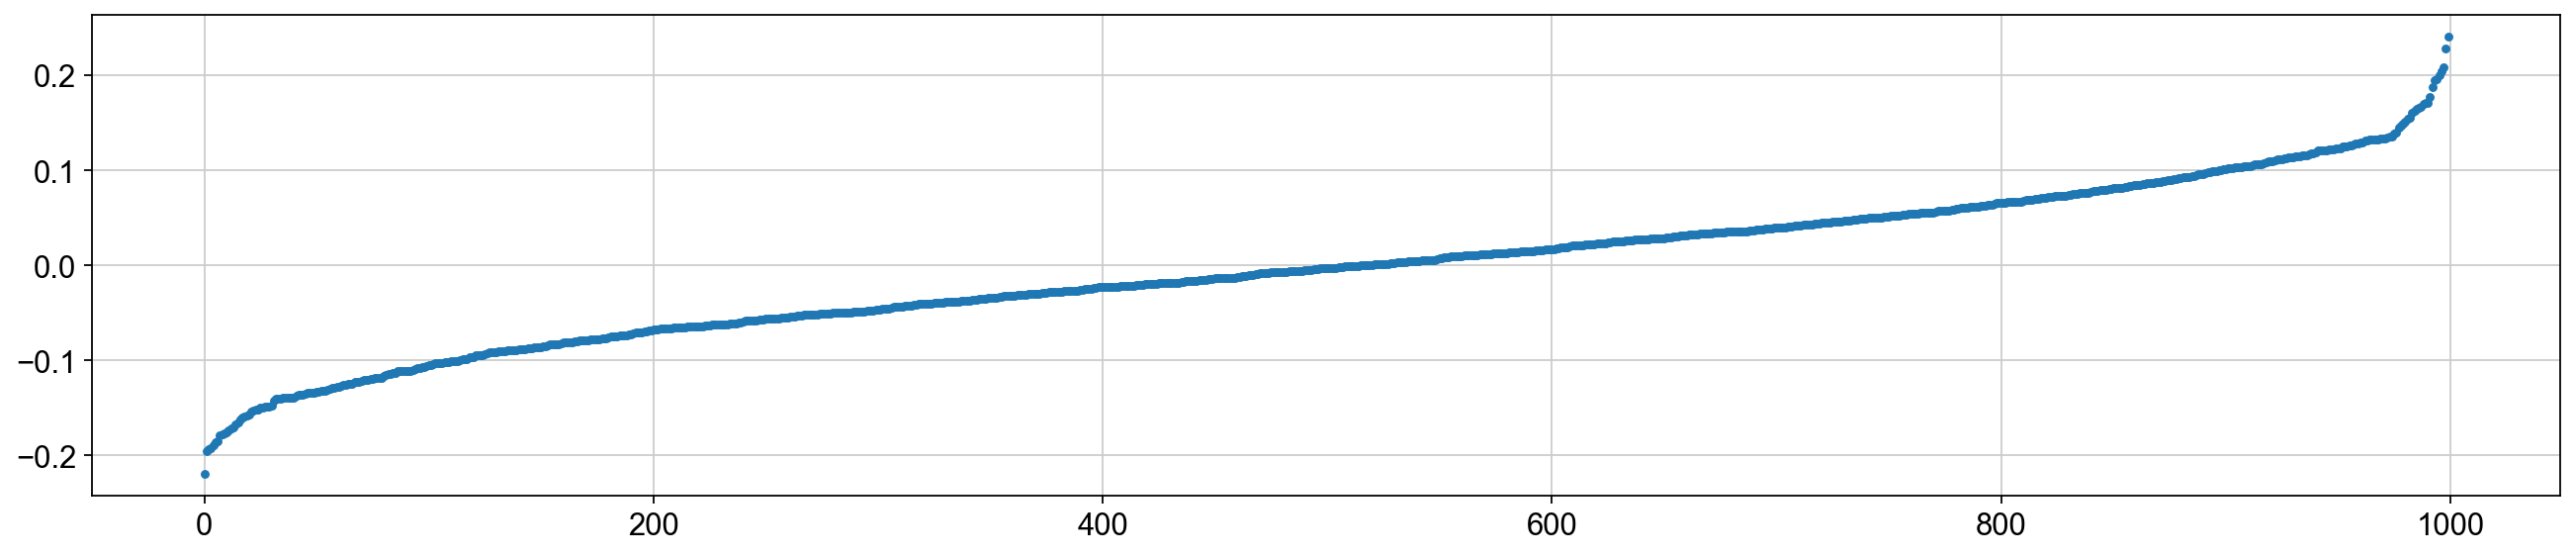

In [167]:
plt.plot(np.sort(hdbscan_corr_over_across_condition_null[:,0]), '.')

In [12]:
for cl in adata_final.obs['hdbscan'].unique():

    gene_id_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
    corr_all = pd.DataFrame(adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].layers['masked_zscore'].T,
                           columns=adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].obs_names).corr()
    corr_all = corr_all.reset_index()
    corr_all = corr_all.rename(columns={'index': 'Index_ID'})
    corr_all_long = pd.melt(corr_all, 
                            id_vars=['Index_ID'],
                            var_name='Column_ID',
                            value_name='Correlation_Value'
                           )
    corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
    corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
    corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]

    hdbscan_corr_rest_over_across_condition, hdbscan_corr_stim8hr_over_across_condition, hdbscan_corr_stim48hr_over_across_condition = corr_enrichment(corr_all_long)

    adata_final.obs.loc[adata_final.obs['hdbscan']==cl, 'hdbscan_corr_rest_over_across_condition'] = hdbscan_corr_rest_over_across_condition
    adata_final.obs.loc[adata_final.obs['hdbscan']==cl, 'hdbscan_corr_stim8hr_over_across_condition'] = hdbscan_corr_stim8hr_over_across_condition
    adata_final.obs.loc[adata_final.obs['hdbscan']==cl, 'hdbscan_corr_stim48hr_over_across_condition'] = hdbscan_corr_stim48hr_over_across_condition
    adata_final.obs.loc[adata_final.obs['hdbscan']==cl, 'cluster_gene_size'] = len(adata_final[adata_final.obs['hdbscan']==cl].obs.target_contrast_corrected.unique())

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_44802/130122697.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.14780054518091962' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata_final.obs.loc[adata_final.obs['hdbscan']==cl, 'hdbscan_corr_rest_over_across_condition'] = hdbscan_corr_rest_over_across_condition
/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_44802/130122697.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7347641445972016' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata_final.obs.loc[adata_final.obs['hdbscan']==cl, 'hdbscan_corr_stim8hr_over_across_condition'] = hdbscan_corr_stim8hr_over_across_condition
/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_44802/130122697.py:

In [13]:
condition_specificity = adata_final.obs[['hdbscan', 'cluster_gene_size', 'hdbscan_corr_rest_over_across_condition',
                                         'hdbscan_corr_stim8hr_over_across_condition', 'hdbscan_corr_stim48hr_over_across_condition']].drop_duplicates().sort_values(by='hdbscan').set_index('hdbscan', drop=True)

In [14]:
condition_specificity = condition_specificity[condition_specificity.cluster_gene_size>=4]

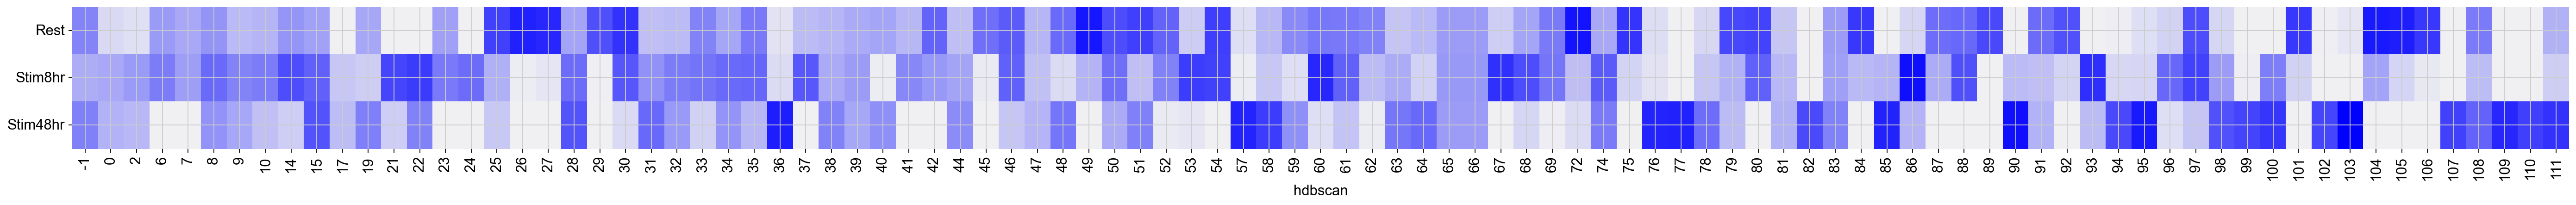

In [91]:
fig, ax = plt.subplots(figsize=(35, 3))
sns.heatmap(condition_specificity.iloc[:,1:].T, vmin=0, vmax=1, ax=ax, cmap=sns.color_palette("light:b", as_cmap=True), cbar=False)
ax.set_yticklabels(['Rest', 'Stim8hr', 'Stim48hr'], rotation=0)
plt.tight_layout()

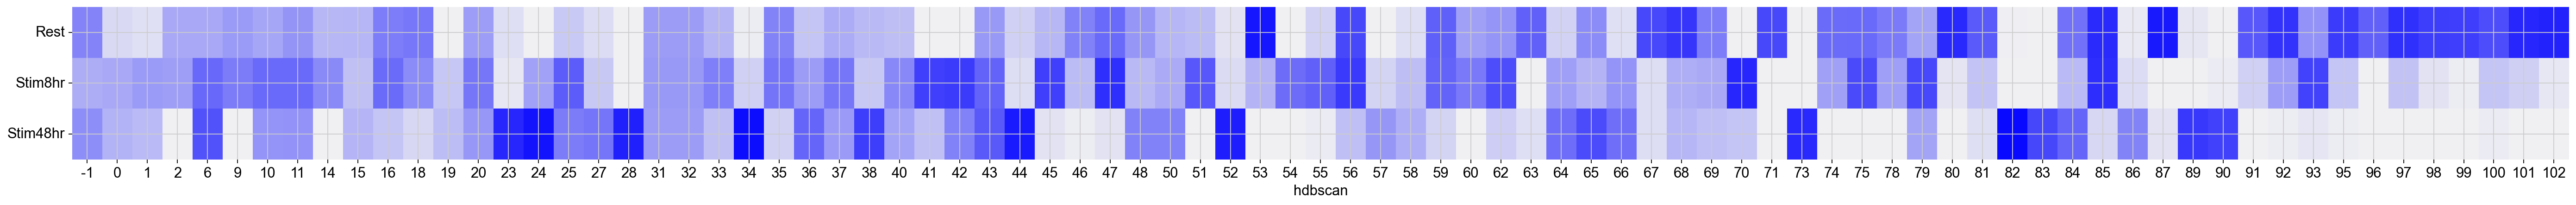

In [101]:
fig, ax = plt.subplots(figsize=(35, 3))
sns.heatmap(condition_specificity.iloc[:,1:].T, vmin=0, vmax=1, ax=ax, cmap=sns.color_palette("light:b", as_cmap=True), cbar=False)
ax.set_yticklabels(['Rest', 'Stim8hr', 'Stim48hr'], rotation=0)
plt.tight_layout()

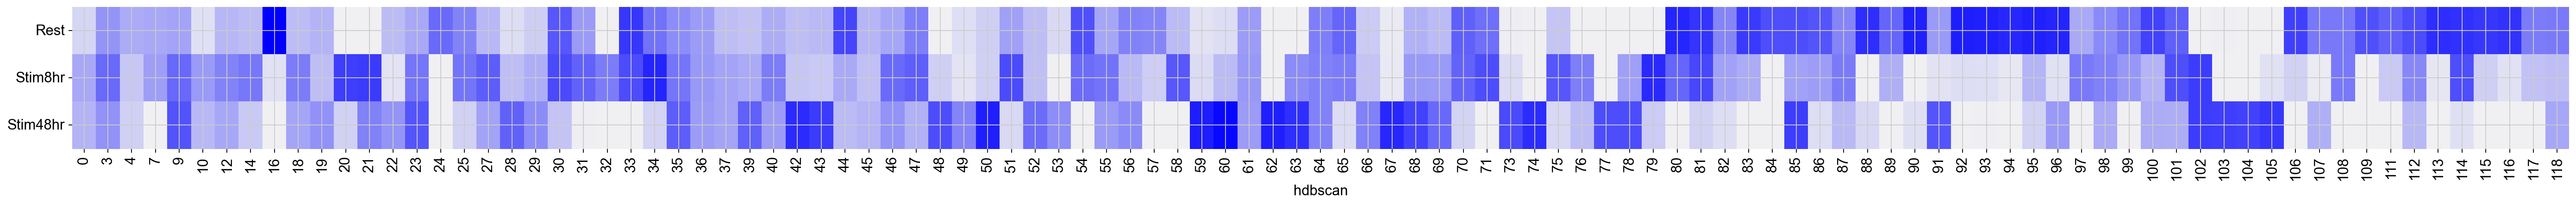

In [11]:
fig, ax = plt.subplots(figsize=(35, 3))
sns.heatmap(condition_specificity.iloc[:,1:].T, vmin=0, vmax=1, ax=ax, cmap=sns.color_palette("light:b", as_cmap=True), cbar=False)
ax.set_yticklabels(['Rest', 'Stim8hr', 'Stim48hr'], rotation=0)
plt.tight_layout()

In [104]:
print(genelist)

['C1D', 'ATXN7L3', 'COLGALT1', 'ATRX', 'LSS', 'VEZT', 'CD3E', 'PEX5', 'GSS', 'RIDA', 'OST4', 'CD2', 'PHF6', 'JUNB', 'CEP135', 'EIF1', 'NUP37', 'PARP14', 'EWSR1', 'TNRC6A', 'FANCL', 'CD247', 'CD3G', 'SAXO5', 'CLCC1', 'NKAPD1', 'TBX22', 'TPGS2', 'NR4A3', 'USO1', 'PGAP2', 'L2HGDH', 'TMEM140', 'C11orf54', 'XRCC2', 'ARL6IP1', 'IKBKB', 'NDFIP2', 'PRKAR1B', 'MAF', 'ATP1B3', 'CAMSAP1', 'KGD4', 'RNF8', 'PLCG1', 'PRKDC', 'KMT2E', 'RPS6KA1', 'CNOT6L', 'ERCC1', 'NCAPG2', 'LSM12', 'BCAT2', 'TLN1', 'FANCB', 'NFIX', 'ERCC4', 'DCAF5', 'NUP188', 'GPI', 'PRKCQ', 'SSB', 'PTPRC', 'CEP89', 'PHF23', 'ADAT3', 'SHOC2', 'YIPF3', 'TMEM263', 'HELT', 'METTL23', 'SLC16A1', 'CLDN7', 'KAT6A', 'OTUB1', 'DCAF4', 'FCHO1', 'MTMR10', 'GALNT6', 'FBXW7', 'EXOC8', 'EML2', 'ZBED3', 'IRF4', 'NUDCD1', 'RAC2', 'CUL4A', 'PYGM', 'CD28', 'GPALPP1', 'LCP2', 'CYB5R4', 'LCK', 'PARP3', 'FMR1', 'HTT', 'SS18L2', 'MAX', 'SRR', 'PPP3R1', 'SZRD1', 'PIBF1', 'RTRAF', 'DNAJC8', 'TBCA', 'MALT1', 'CCDC134', 'MEN1', 'TMX1', 'SOCS4', 'UBIAD1', 'F

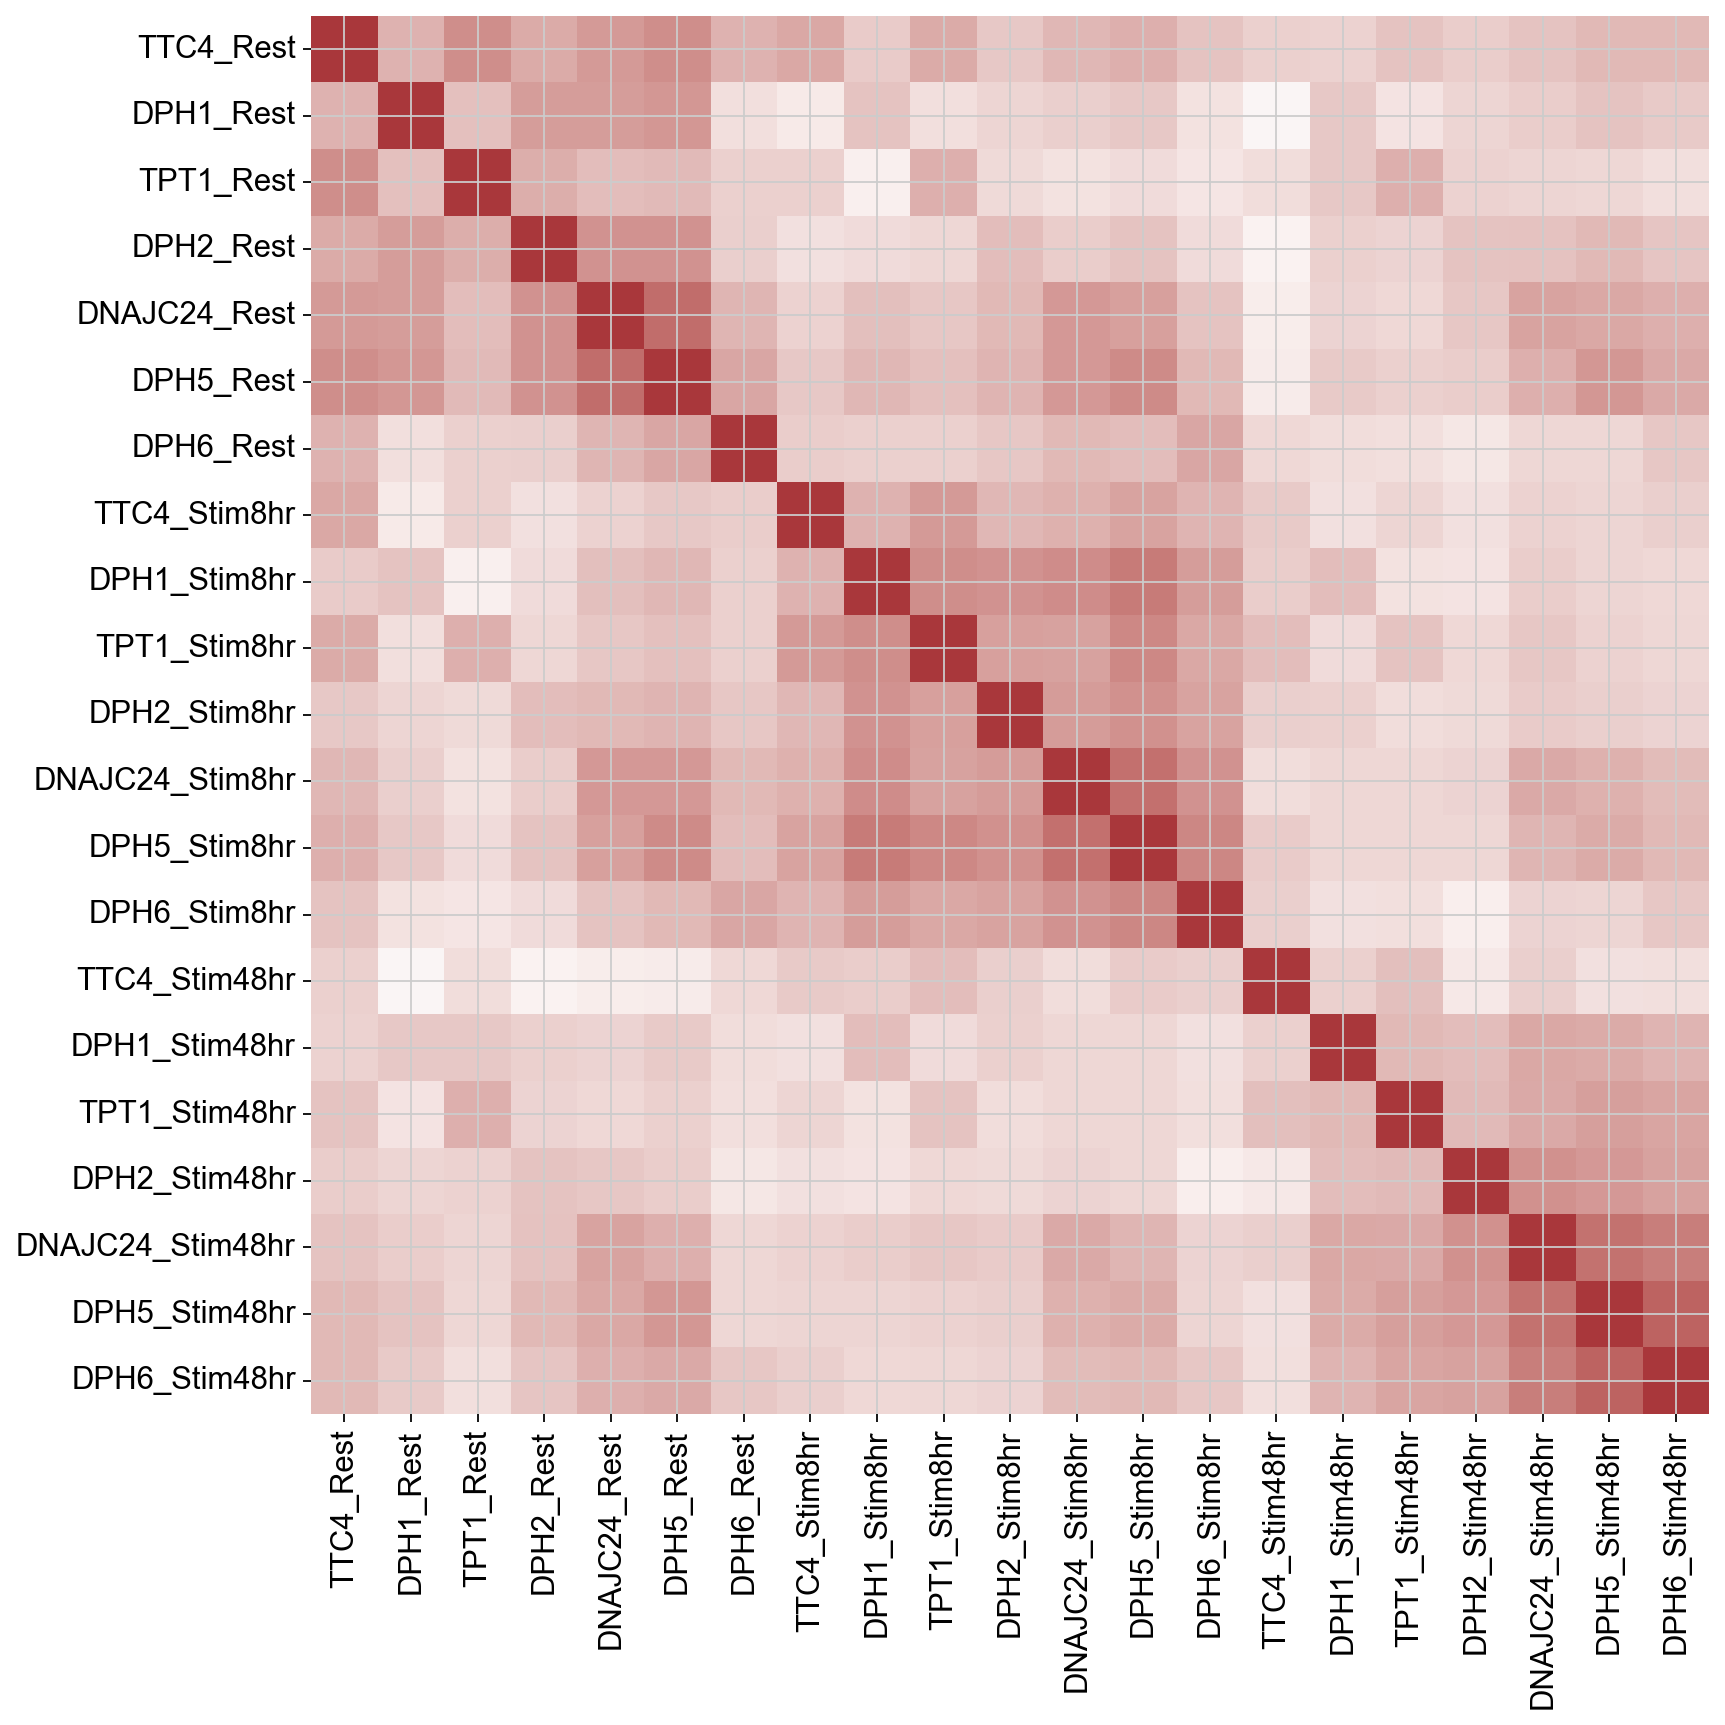

In [168]:
cl = 8
thres = 0.7
plt.figure(figsize=(11, 11))
genelist = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_gene_name_corrected.unique().tolist()
corr_mtx = corr_compute(adata_de, genelist)

# Reorder regulator based on hierarchical clustering of regulators in main conditions
# For each cluster, get regulator member list
regulator = adata_final[adata_final.obs['hdbscan']==cl].obs['target_contrast_gene_name_corrected'].unique().tolist()
main_condition = adata_final[adata_final.obs['hdbscan']==cl].obs['culture_condition'].value_counts().index[0]
regulator_main_condition = [item+'_'+main_condition for item in regulator]

# Get reordered downstream genes based on DE effect of main condition
clustermap = sns.clustermap(corr_mtx.loc[regulator_main_condition, regulator_main_condition], 
                            method='average', 
                            metric='euclidean')
xticklabel_indices = clustermap.dendrogram_col.reordered_ind
plt.close(clustermap.fig)
regulator_reordered = np.array(regulator)[xticklabel_indices]

target_names_rest = adata_de[adata_de.obs['culture_condition']=='Rest'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_rest)
regulator_rest = regulator_reordered[isin_mask]
regulator_rest = [item+'_Rest' for item in regulator_rest]
target_names_stim8hr = adata_de[adata_de.obs['culture_condition']=='Stim8hr'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_stim8hr)
regulator_stim8hr = regulator_reordered[isin_mask]
regulator_stim8hr = [item+'_Stim8hr' for item in regulator_stim8hr]
target_names_stim48hr = adata_de[adata_de.obs['culture_condition']=='Stim48hr'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_stim48hr)
regulator_stim48hr = regulator_reordered[isin_mask]
regulator_stim48hr = [item+'_Stim48hr' for item in regulator_stim48hr]
regulator_all = np.concatenate([regulator_rest, regulator_stim8hr, regulator_stim48hr])

sns.heatmap(corr_mtx.loc[regulator_all, regulator_all], vmin=-thres, vmax=thres, cmap='vlag', cbar=False)#, xticklabels=False, yticklabels=False)
#plt.xlabel('Perturbed genes (n='+str(len(genelist))+')', fontsize=32, labelpad=5)
#plt.ylabel('Perturbed genes (n='+str(len(genelist))+')', fontsize=32, labelpad=5)
plt.tight_layout()
#plt.savefig('./results/cluster'+str(cl)+'.png')

In [13]:
condition_specificity.iloc[:20]

,cluster_gene_size,hdbscan_corr_rest_over_across_condition,hdbscan_corr_stim8hr_over_across_condition,hdbscan_corr_stim48hr_over_across_condition
hdbscan,,,,
-1,340,0.450177,0.278371,0.409803
0,7,0.101049,0.301788,0.259798
1,10,0.067932,0.362164,0.230183
2,10,0.304567,0.343471,-0.052825
6,83,0.303148,0.570250,0.658642
9,6,0.360499,0.485956,0.000162
10,6,0.311204,0.558934,0.387117
11,7,0.385626,0.562759,0.394317
14,41,0.238456,0.432682,-0.157230


In [15]:
de_summary_stats[de_summary_stats.target_name=='PPA2']

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category,target_contrast_corrected,obs_names,target_name_corrected
7008,ENSG00000138777,PPA2,Rest,176.0,553,314,867,0.0,False,NaN,False,>10 DE genes,no on-target KD,ENSG00000138777,ENSG00000138777_Rest,PPA2
25558,ENSG00000138777,PPA2,Stim8hr,164.0,150,110,260,0.0,False,NaN,False,>10 DE genes,no on-target KD,ENSG00000138777,ENSG00000138777_Stim8hr,PPA2


In [13]:
adata_final[adata_final.obs.target_contrast_gene_name_corrected.isin(['STAT5B', 'IL4R', 'STAT3', 'RASA2', 'PPA2'])].obs.sort_values(by='target_contrast_gene_name_corrected')

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan
ENSG00000077238_Stim8hr,IL4R,Stim8hr,ENSG00000077238,222,903.0,ENSG00000077238,IL4R,88
ENSG00000077238_Stim48hr,IL4R,Stim48hr,ENSG00000077238,476,911.0,ENSG00000077238,IL4R,85
ENSG00000138777_Rest,PPA2,Rest,ENSG00000138777,140,176.0,ENSG00000138777,PPA2,48
ENSG00000138777_Stim8hr,PPA2,Stim8hr,ENSG00000138777,511,164.0,ENSG00000138777,PPA2,-1
ENSG00000155903_Stim48hr,RASA2,Stim48hr,ENSG00000155903,319,420.0,ENSG00000155903,RASA2,88
ENSG00000155903_Stim8hr,RASA2,Stim8hr,ENSG00000155903,385,471.0,ENSG00000155903,RASA2,80
ENSG00000155903_Rest,RASA2,Rest,ENSG00000155903,630,416.0,ENSG00000155903,RASA2,75
ENSG00000168610_Rest,STAT3,Rest,ENSG00000168610,241,239.0,ENSG00000168610,STAT3,106
ENSG00000168610_Stim48hr,STAT3,Stim48hr,ENSG00000168610,409,241.0,ENSG00000168610,STAT3,90
ENSG00000168610_Stim8hr,STAT3,Stim8hr,ENSG00000168610,536,255.0,ENSG00000168610,STAT3,79


In [12]:
adata_final[adata_final.obs.hdbscan==99].obs.sort_values(by='target_contrast_gene_name_corrected')

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan
ENSG00000157426_Stim48hr,AASDH,Stim48hr,ENSG00000157426,643,515.0,ENSG00000157426,AASDH,99
ENSG00000189007_Stim48hr,ADAT2,Stim48hr,ENSG00000189007,677,333.0,ENSG00000189007,ADAT2,99
ENSG00000213638_Stim48hr,ADAT3,Stim48hr,ENSG00000213638,294,292.0,ENSG00000213638,ADAT3,99
ENSG00000168876_Stim48hr,ANKRD49,Stim48hr,ENSG00000168876,506,133.0,ENSG00000168876,ANKRD49,99
ENSG00000157999_Stim48hr,ANKRD61,Stim48hr,ENSG00000157999,586,1001.0,ENSG00000157999,ANKRD61,99
...,...,...,...,...,...,...,...,...
ENSG00000115085_Stim48hr,ZAP70,Stim48hr,ENSG00000115085,512,52.0,ENSG00000115085,ZAP70,99
ENSG00000135482_Stim48hr,ZC3H10,Stim48hr,ENSG00000135482,392,892.0,ENSG00000135482,ZC3H10,99
ENSG00000183779_Stim48hr,ZNF703,Stim48hr,ENSG00000183779,303,63.0,ENSG00000183779,ZNF703,99
ENSG00000152475_Stim48hr,ZNF837,Stim48hr,ENSG00000152475,570,389.0,ENSG00000152475,ZNF837,99


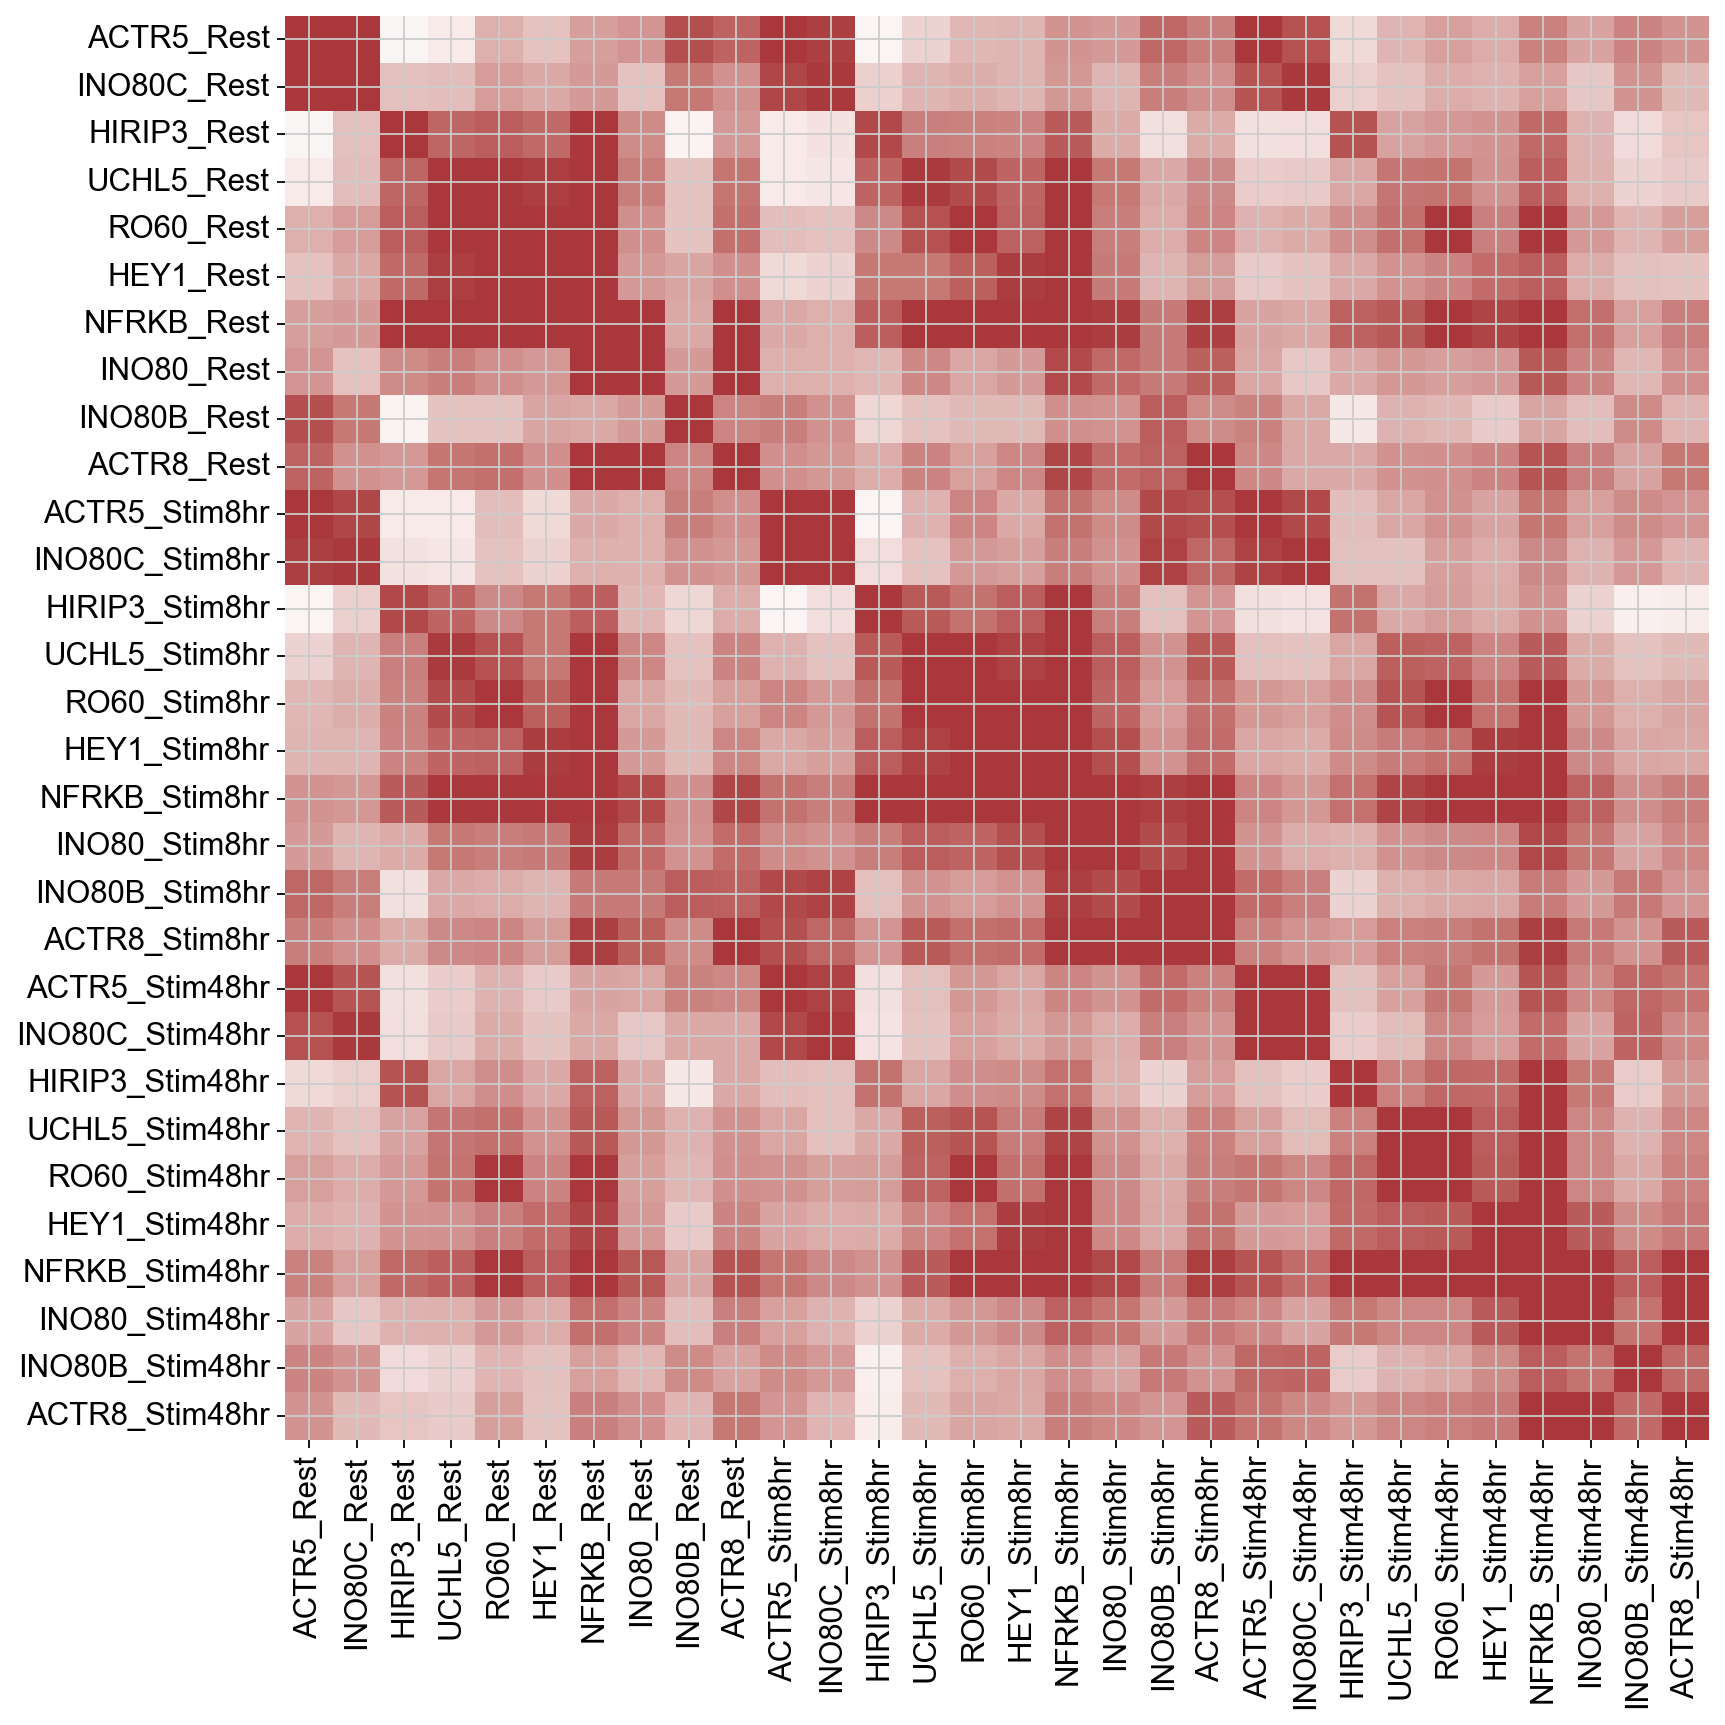

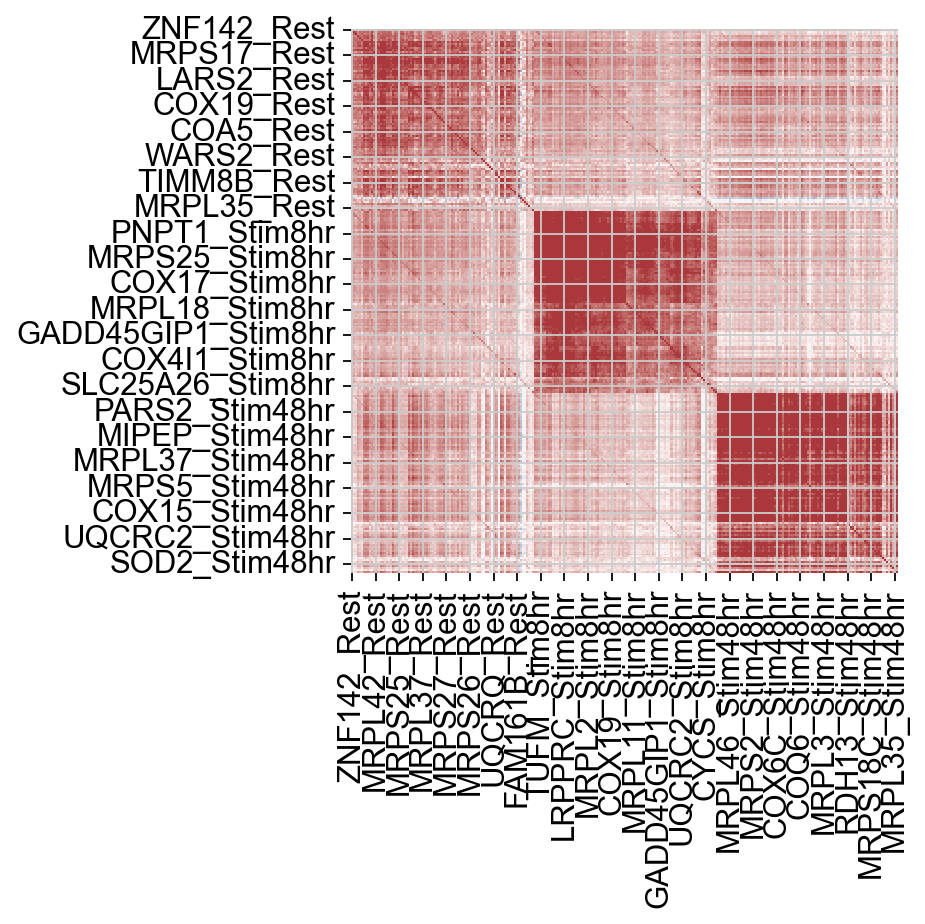

In [113]:
cl = 48
thres = 0.4
plt.figure(figsize=(6, 6))
genelist = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_gene_name_corrected.unique().tolist()
corr_mtx = corr_compute(adata_de, genelist)

# Reorder regulator based on hierarchical clustering of regulators in main conditions
# For each cluster, get regulator member list
regulator = adata_final[adata_final.obs['hdbscan']==cl].obs['target_contrast_gene_name_corrected'].unique().tolist()
main_condition = adata_final[adata_final.obs['hdbscan']==cl].obs['culture_condition'].value_counts().index[0]
regulator_main_condition = [item+'_'+main_condition for item in regulator]

# Get reordered downstream genes based on DE effect of main condition
clustermap = sns.clustermap(corr_mtx.loc[regulator_main_condition, regulator_main_condition], 
                            method='average', 
                            metric='euclidean')
xticklabel_indices = clustermap.dendrogram_col.reordered_ind
plt.close(clustermap.fig)
regulator_reordered = np.array(regulator)[xticklabel_indices]

target_names_rest = adata_de[adata_de.obs['culture_condition']=='Rest'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_rest)
regulator_rest = regulator_reordered[isin_mask]
regulator_rest = [item+'_Rest' for item in regulator_rest]
target_names_stim8hr = adata_de[adata_de.obs['culture_condition']=='Stim8hr'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_stim8hr)
regulator_stim8hr = regulator_reordered[isin_mask]
regulator_stim8hr = [item+'_Stim8hr' for item in regulator_stim8hr]
target_names_stim48hr = adata_de[adata_de.obs['culture_condition']=='Stim48hr'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_stim48hr)
regulator_stim48hr = regulator_reordered[isin_mask]
regulator_stim48hr = [item+'_Stim48hr' for item in regulator_stim48hr]
regulator_all = np.concatenate([regulator_rest, regulator_stim8hr, regulator_stim48hr])

sns.heatmap(corr_mtx.loc[regulator_all, regulator_all], vmin=-thres, vmax=thres, cmap='vlag', cbar=False)#, xticklabels=False, yticklabels=False)
#plt.xlabel('Perturbed genes (n='+str(len(genelist))+')', fontsize=32, labelpad=5)
#plt.ylabel('Perturbed genes (n='+str(len(genelist))+')', fontsize=32, labelpad=5)
plt.tight_layout()
#plt.savefig('./results/cluster'+str(cl)+'.png')

In [105]:
regulator

['SLC24A1',
 'ARID5B',
 'INTS13',
 'INTS15',
 'FGFR1OP2',
 'INTS14',
 'INTS10',
 'EBF3']

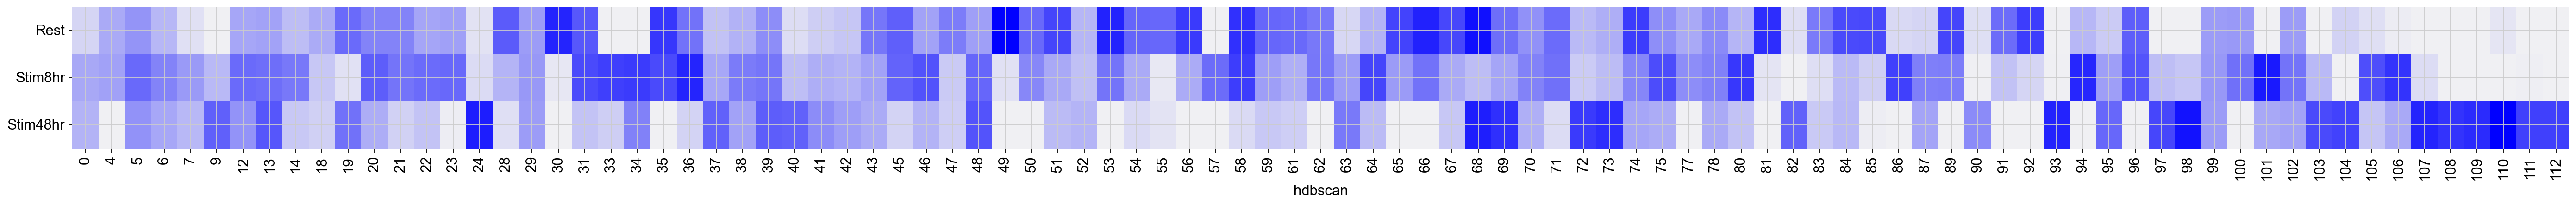

In [40]:
fig, ax = plt.subplots(figsize=(35, 3))
sns.heatmap(condition_specificity.iloc[:,1:].T, vmin=0, vmax=1, ax=ax, cmap=sns.color_palette("light:b", as_cmap=True), cbar=False)
ax.set_yticklabels(['Rest', 'Stim8hr', 'Stim48hr'], rotation=0)
plt.tight_layout()

In [120]:
hdbscan_order = np.array([0, 1, 2, 6, 7, 
                          14, 13, 25, 84, 
                          15, 
                          36, 60, 67, 
                          40, 53, 
                          43, 
                          97, 108,
                          39, 45, 55, 68, 78, 86, 92, # unknown, not specific
                          56,
                          73, 87, 94, 58, # cell cycle upstream
                          65, # unknown, stim8hr
                          61, 66, 74, 88, # unknown, rest & stim8hr
                          72, 90, 96, # unknown, rest
                          54, # stim48hr
                          98, # stim48hr
                          69, # stim48hr
                          107,
                          37, 109, 
                          77, 83, 102, 104]) # unknown, stim48hr

In [49]:
adata_final[adata_final.obs.target_contrast_gene_name_corrected=='COG6'].obs.sort_values(by='target_contrast_gene_name_corrected')

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan,hdbscan_corr_rest_over_across_condition,hdbscan_corr_stim8hr_over_across_condition,hdbscan_corr_stim48hr_over_across_condition,cluster_gene_size
ENSG00000133103_Rest,COG6,Rest,ENSG00000133103,236,161.0,ENSG00000133103,COG6,58,0.798696,0.744979,0.096815,67
ENSG00000133103_Stim8hr,COG6,Stim8hr,ENSG00000133103,657,159.0,ENSG00000133103,COG6,33,-0.143934,0.736620,0.142546,135
ENSG00000133103_Stim48hr,COG6,Stim48hr,ENSG00000133103,663,110.0,ENSG00000133103,COG6,111,-0.073820,0.013376,0.731200,190


In [54]:
print(adata_final[adata_final.obs.hdbscan==111].obs.target_contrast_gene_name.tolist())

['MED14', 'PPP1R32', 'GPS2', 'BICDL1', 'C1D', 'CEPT1', 'XRRA1', 'COLGALT1', 'COPS9', 'ATRX', 'VEZT', 'PEX5', 'GSS', 'OST4', 'CD2', 'PHF6', 'FANCF', 'CEP135', 'SRSF11', 'EIF1', 'NUP37', 'EWSR1', 'TNRC6A', 'FANCL', 'ATF7IP', 'CD247', 'AKAP17A', 'CD3G', 'TEX45', 'CLCC1', 'NKAPD1', 'TBX22', 'ANAPC10', 'TPGS2', 'NR4A3', 'PGAP2', 'LRRC8B', 'L2HGDH', 'TMEM140', 'C11orf54', 'ELMOD3', 'ARL6IP1', 'IKBKB', 'SMARCD1', 'NDFIP2', 'MAF', 'PCYT2', 'ATP1B3', 'CAMSAP1', 'MRPS36', 'WNK1', 'RNF8', 'PLCG1', 'KMT2E', 'TPRG1L', 'RPS6KA1', 'ABHD13', 'DMRTA2', 'ST8SIA1', 'CNOT6L', 'ERCC1', 'SNAP23', 'NCAPG2', 'LSM12', 'FANCB', 'NFIX', 'ERCC4', 'PKN3', 'DCAF5', 'NUP188', 'GPI', 'ELOB', 'PRKCQ', 'PTPRC', 'CEP89', 'PHF23', 'ADAT3', 'SHOC2', 'YIPF3', 'TMEM263', 'HELT', 'ICE2', 'METTL23', 'CAPZA1', 'ATF7IP2', 'CLDN7', 'OTUB1', 'DCAF4', 'FCHO1', 'MTMR10', 'GALNT6', 'FBXW7', 'EXOC8', 'ZNF384', 'EML2', 'ATAD5', 'MUM1', 'NDUFB7', 'NUDCD1', 'RAC2', 'CUL4A', 'PYGM', 'CD28', 'ARRDC4', 'STAT5A', 'STAT6', 'CYB5R4', 'NUPL2',

In [21]:
cl = 49
gene_id_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
corr_all = pd.DataFrame(adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].layers['masked_zscore'].T,
                       columns=adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].obs_names).corr()
corr_all = corr_all.reset_index()
corr_all = corr_all.rename(columns={'index': 'Index_ID'})
corr_all_long = pd.melt(corr_all, 
                        id_vars=['Index_ID'],
                        var_name='Column_ID',
                        value_name='Correlation_Value'
                       )
corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]

corr_across_condition = corr_all_long[corr_all_long.perturbation_1_condition!=corr_all_long.perturbation_2_condition].Correlation_Value.median()

corr_rest = corr_all_long[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Rest')].Correlation_Value.median()
corr_stim8hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Stim8hr')].Correlation_Value.median()
corr_stim48hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim48hr')&(corr_all_long.perturbation_2_condition=='Stim48hr')].Correlation_Value.median()

corr_max = np.max([corr_rest, corr_stim8hr, corr_stim48hr, corr_across_condition])

corr_rest, corr_stim8hr, corr_stim48hr, corr_across_condition,\
(corr_rest - corr_across_condition)/corr_max,\
(corr_stim8hr - corr_across_condition)/corr_max,\
(corr_stim48hr - corr_across_condition)/corr_max

(0.18395589694459183,
 0.006430839671764169,
 -0.011248680690649257,
 -0.005330064813342776,
 1.0289746885088886,
 0.06393328336002935,
 -0.032174102464838025)

In [22]:
cl = 0
gene_id_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
corr_all = pd.DataFrame(adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].layers['masked_zscore'].T,
                       columns=adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].obs_names).corr()
corr_all = corr_all.reset_index()
corr_all = corr_all.rename(columns={'index': 'Index_ID'})
corr_all_long = pd.melt(corr_all, 
                        id_vars=['Index_ID'],
                        var_name='Column_ID',
                        value_name='Correlation_Value'
                       )
corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]

corr_across_condition = corr_all_long[corr_all_long.perturbation_1_condition!=corr_all_long.perturbation_2_condition].Correlation_Value.median()

corr_rest = corr_all_long[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Rest')].Correlation_Value.median()
corr_stim8hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Stim8hr')].Correlation_Value.median()
corr_stim48hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim48hr')&(corr_all_long.perturbation_2_condition=='Stim48hr')].Correlation_Value.median()

corr_max = np.max([corr_rest, corr_stim8hr, corr_stim48hr, corr_across_condition])

corr_rest, corr_stim8hr, corr_stim48hr, corr_across_condition,\
(corr_rest - corr_across_condition)/corr_max,\
(corr_stim8hr - corr_across_condition)/corr_max,\
(corr_stim48hr - corr_across_condition)/corr_max

(0.37982428772240495,
 0.4672924528695795,
 0.44453184142213575,
 0.3254618580753062,
 0.11633491898545859,
 0.3035156975536645,
 0.2548082739527184)

In [23]:
cl = 5
gene_id_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
corr_all = pd.DataFrame(adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].layers['masked_zscore'].T,
                       columns=adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].obs_names).corr()
corr_all = corr_all.reset_index()
corr_all = corr_all.rename(columns={'index': 'Index_ID'})
corr_all_long = pd.melt(corr_all, 
                        id_vars=['Index_ID'],
                        var_name='Column_ID',
                        value_name='Correlation_Value'
                       )
corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]

corr_across_condition = corr_all_long[corr_all_long.perturbation_1_condition!=corr_all_long.perturbation_2_condition].Correlation_Value.median()

corr_rest = corr_all_long[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Rest')].Correlation_Value.median()
corr_stim8hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Stim8hr')].Correlation_Value.median()
corr_stim48hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim48hr')&(corr_all_long.perturbation_2_condition=='Stim48hr')].Correlation_Value.median()

corr_max = np.max([corr_rest, corr_stim8hr, corr_stim48hr, corr_across_condition])

corr_rest, corr_stim8hr, corr_stim48hr, corr_across_condition,\
(corr_rest - corr_across_condition)/corr_max,\
(corr_stim8hr - corr_across_condition)/corr_max,\
(corr_stim48hr - corr_across_condition)/corr_max

(0.28008058488579707,
 0.34037159779136544,
 0.2830389071207588,
 0.14882457080475586,
 0.3856256366064246,
 0.5627585504476212,
 0.3943170851707524)

In [24]:
cl = 13
gene_id_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
corr_all = pd.DataFrame(adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].layers['masked_zscore'].T,
                       columns=adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].obs_names).corr()
corr_all = corr_all.reset_index()
corr_all = corr_all.rename(columns={'index': 'Index_ID'})
corr_all_long = pd.melt(corr_all, 
                        id_vars=['Index_ID'],
                        var_name='Column_ID',
                        value_name='Correlation_Value'
                       )
corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]

corr_across_condition = corr_all_long[corr_all_long.perturbation_1_condition!=corr_all_long.perturbation_2_condition].Correlation_Value.median()

corr_rest = corr_all_long[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Rest')].Correlation_Value.median()
corr_stim8hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Stim8hr')].Correlation_Value.median()
corr_stim48hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim48hr')&(corr_all_long.perturbation_2_condition=='Stim48hr')].Correlation_Value.median()

corr_max = np.max([corr_rest, corr_stim8hr, corr_stim48hr, corr_across_condition])

corr_rest, corr_stim8hr, corr_stim48hr, corr_across_condition,\
(corr_rest - corr_across_condition)/corr_max,\
(corr_stim8hr - corr_across_condition)/corr_max,\
(corr_stim48hr - corr_across_condition)/corr_max

(0.30221506503252626,
 0.3976965571760571,
 0.44112596619722627,
 0.15850405307682894,
 0.3257822548841854,
 0.5422317488159059,
 0.6406830129651397)

In [20]:
cl = 30
gene_id_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
corr_all = pd.DataFrame(adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].layers['masked_zscore'].T,
                       columns=adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].obs_names).corr()
corr_all = corr_all.reset_index()
corr_all = corr_all.rename(columns={'index': 'Index_ID'})
corr_all_long = pd.melt(corr_all, 
                        id_vars=['Index_ID'],
                        var_name='Column_ID',
                        value_name='Correlation_Value'
                       )
corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]

corr_across_condition = corr_all_long[corr_all_long.perturbation_1_condition!=corr_all_long.perturbation_2_condition].Correlation_Value.median()

corr_rest = corr_all_long[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Rest')].Correlation_Value.median()
corr_stim8hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Stim8hr')].Correlation_Value.median()
corr_stim48hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim48hr')&(corr_all_long.perturbation_2_condition=='Stim48hr')].Correlation_Value.median()

corr_max = np.max([corr_rest, corr_stim8hr, corr_stim48hr, corr_across_condition])

corr_rest, corr_stim8hr, corr_stim48hr, corr_across_condition,\
(corr_rest - corr_across_condition)/corr_across_condition,\
(corr_stim8hr - corr_across_condition)/corr_across_condition,\
(corr_stim48hr - corr_across_condition)/corr_across_condition

(0.3385712235653755,
 0.06513158505814037,
 0.034751644527588055,
 0.05060617180185886,
 5.690314866949471,
 0.28702849354331056,
 -0.3132923655309655)

In [23]:
condition_specificity

,cluster_gene_size,hdbscan_corr_rest_over_across_condition,hdbscan_corr_stim8hr_over_across_condition,hdbscan_corr_stim48hr_over_across_condition
hdbscan,,,,
0,8,0.092219,0.313111,0.263539
4,9,0.246074,0.327720,-0.032563
5,7,0.381060,0.544103,0.337025
6,36,0.253276,0.429480,0.312972
7,11,0.179153,0.317840,0.247141
9,5,0.281590,0.334746,0.129971
12,6,0.349313,0.540194,0.332986
13,57,0.326802,0.526268,0.622065
14,49,0.228539,0.495505,0.184489


In [ ]:
condition_specificity

In [112]:
def corr_compute(adata, gene_list):
    mask = adata.obs.target_contrast_gene_name_corrected.isin(genelist)
    rest = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name_corrected').index].X.copy()
    stim8hr = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].X.copy()
    stim48hr = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].X.copy()
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.culture_condition.values.tolist()
    ind = [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    
    data = np.concatenate([rest, stim8hr, stim48hr])
            
    test = pd.DataFrame(data=data,
                        index=ind,
                        columns=adata.var_names)
    test2 = test.T.corr()
    return test2

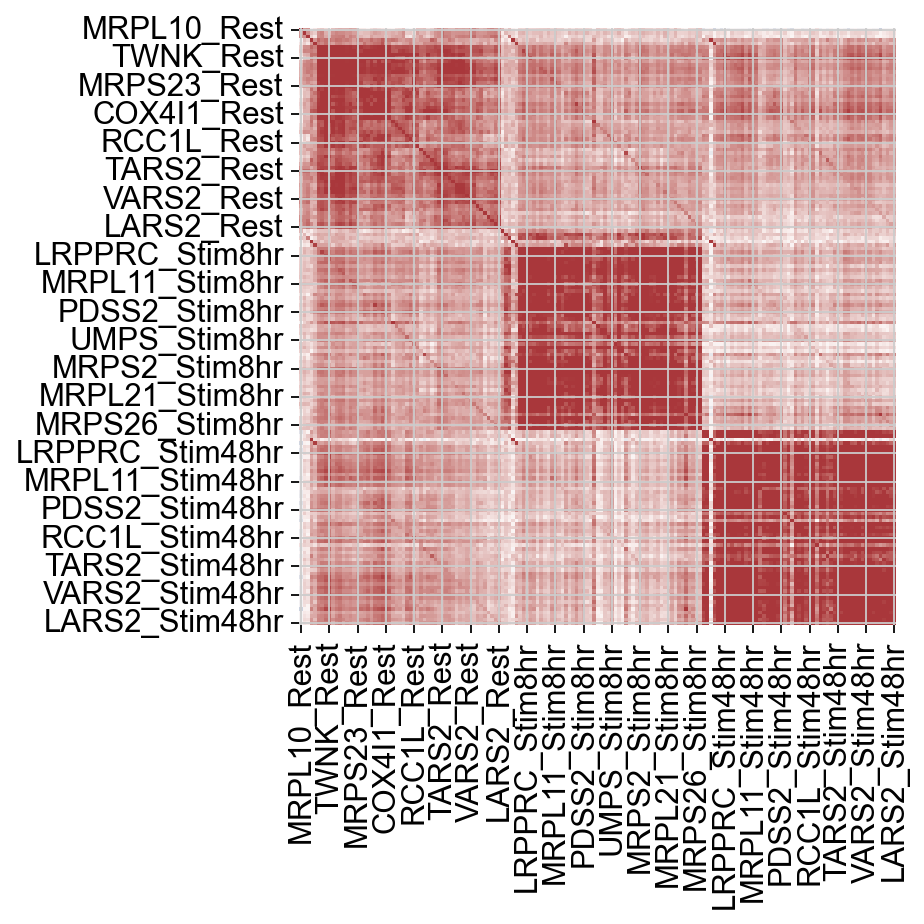

In [19]:
cl = 13
thres = 0.4
plt.figure(figsize=(6, 6))
genelist = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_gene_name_corrected.unique().tolist()
corr_mtx = corr_compute(adata_de, genelist)

# Reorder regulator based on hierarchical clustering of regulators in main conditions
# For each cluster, get regulator member list
regulator = adata_final[adata_final.obs['hdbscan']==cl].obs['target_contrast_gene_name_corrected'].unique().tolist()
main_condition = adata_final[adata_final.obs['hdbscan']==cl].obs['culture_condition'].value_counts().index[0]
regulator_main_condition = [item+'_'+main_condition for item in regulator]

# Get reordered downstream genes based on DE effect of main condition
clustermap = sns.clustermap(corr_mtx.loc[regulator_main_condition, regulator_main_condition], 
                            method='average', 
                            metric='euclidean')
xticklabel_indices = clustermap.dendrogram_col.reordered_ind
plt.close(clustermap.fig)
regulator_reordered = np.array(regulator)[xticklabel_indices]

target_names_rest = adata_de[adata_de.obs['culture_condition']=='Rest'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_rest)
regulator_rest = regulator_reordered[isin_mask]
regulator_rest = [item+'_Rest' for item in regulator_rest]
target_names_stim8hr = adata_de[adata_de.obs['culture_condition']=='Stim8hr'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_stim8hr)
regulator_stim8hr = regulator_reordered[isin_mask]
regulator_stim8hr = [item+'_Stim8hr' for item in regulator_stim8hr]
target_names_stim48hr = adata_de[adata_de.obs['culture_condition']=='Stim48hr'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_stim48hr)
regulator_stim48hr = regulator_reordered[isin_mask]
regulator_stim48hr = [item+'_Stim48hr' for item in regulator_stim48hr]
regulator_all = np.concatenate([regulator_rest, regulator_stim8hr, regulator_stim48hr])

sns.heatmap(corr_mtx.loc[regulator_all, regulator_all], vmin=-thres, vmax=thres, cmap='vlag', cbar=False)#, xticklabels=False, yticklabels=False)
#plt.xlabel('Perturbed genes (n='+str(len(genelist))+')', fontsize=32, labelpad=5)
#plt.ylabel('Perturbed genes (n='+str(len(genelist))+')', fontsize=32, labelpad=5)
plt.tight_layout()
#plt.savefig('./results/cluster'+str(cl)+'.png')

In [180]:
cl = 0
gene_id_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
corr_all = pd.DataFrame(adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].layers['zscore'].T,
                       columns=adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].obs_names).corr()
corr_all = corr_all.reset_index()
corr_all = corr_all.rename(columns={'index': 'Index_ID'})
corr_all_long = pd.melt(corr_all, 
                        id_vars=['Index_ID'],
                        var_name='Column_ID',
                        value_name='Correlation_Value'
                       )
corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]

corr_across_condition_mean = corr_all_long[corr_all_long.perturbation_1_condition!=corr_all_long.perturbation_2_condition].Correlation_Value.mean()

corr_rest_mean = corr_all_long[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Rest')].Correlation_Value.mean()
corr_stim8hr_mean = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Stim8hr')].Correlation_Value.mean()
corr_stim48hr_mean = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim48hr')&(corr_all_long.perturbation_2_condition=='Stim48hr')].Correlation_Value.mean()

In [181]:
corr_across_condition_mean

0.27617561369139526

In [182]:
corr_rest_mean, corr_stim8hr_mean, corr_stim48hr_mean

(0.3772636894623014, 0.41080414908189233, 0.26279878782443)

In [183]:
regulator_main_condition

['CASC3_Stim8hr',
 'SMG7_Stim8hr',
 'SMG9_Stim8hr',
 'SRR_Stim8hr',
 'XRN1_Stim8hr',
 'UPF2_Stim8hr',
 'SMG1_Stim8hr',
 'SMG8_Stim8hr',
 'TMEM79_Stim8hr']

In [127]:
regulator_reordered

array(['PIM1', 'GATAD1', 'GATAD1', 'PHF12', 'PHF12', 'PHF12', 'SIN3B',
       'SIN3B', 'SIN3B'], dtype='<U6')

In [126]:
regulator_rest

['PIM1_Rest',
 'GATAD1_Rest',
 'GATAD1_Rest',
 'PHF12_Rest',
 'PHF12_Rest',
 'PHF12_Rest',
 'SIN3B_Rest',
 'SIN3B_Rest',
 'SIN3B_Rest']

In [125]:
regulator_all

array(['PIM1_Rest', 'GATAD1_Rest', 'GATAD1_Rest', 'PHF12_Rest',
       'PHF12_Rest', 'PHF12_Rest', 'SIN3B_Rest', 'SIN3B_Rest',
       'SIN3B_Rest', 'PIM1_Stim8hr', 'GATAD1_Stim8hr', 'GATAD1_Stim8hr',
       'PHF12_Stim8hr', 'PHF12_Stim8hr', 'PHF12_Stim8hr', 'SIN3B_Stim8hr',
       'SIN3B_Stim8hr', 'SIN3B_Stim8hr', 'GATAD1_Stim48hr',
       'GATAD1_Stim48hr', 'PHF12_Stim48hr', 'PHF12_Stim48hr',
       'PHF12_Stim48hr', 'SIN3B_Stim48hr', 'SIN3B_Stim48hr',
       'SIN3B_Stim48hr'], dtype='<U15')

In [124]:
corr_mtx

,GATAD1_Rest,PHF12_Rest,PIM1_Rest,SIN3B_Rest,GATAD1_Stim8hr,PHF12_Stim8hr,PIM1_Stim8hr,SIN3B_Stim8hr,GATAD1_Stim48hr,PHF12_Stim48hr,SIN3B_Stim48hr
GATAD1_Rest,1.000000,0.261294,0.353681,0.459397,0.217486,0.228700,0.126759,0.314830,0.257321,0.269159,0.389063
PHF12_Rest,0.261294,1.000000,0.349827,0.504099,0.251890,0.337057,0.263746,0.394425,0.215424,0.336632,0.361644
PIM1_Rest,0.353681,0.349827,1.000000,0.468329,0.186534,0.240274,0.337182,0.297659,0.196700,0.243432,0.340756
SIN3B_Rest,0.459397,0.504099,0.468329,1.000000,0.345852,0.368852,0.330362,0.596259,0.334250,0.411513,0.606398
GATAD1_Stim8hr,0.217486,0.251890,0.186534,0.345852,1.000000,0.377575,0.311144,0.470233,0.215212,0.238878,0.321314
PHF12_Stim8hr,0.228700,0.337057,0.240274,0.368852,0.377575,1.000000,0.363334,0.511770,0.207884,0.322089,0.358357
PIM1_Stim8hr,0.126759,0.263746,0.337182,0.330362,0.311144,0.363334,1.000000,0.392735,0.129980,0.207301,0.277003
SIN3B_Stim8hr,0.314830,0.394425,0.297659,0.596259,0.470233,0.511770,0.392735,1.000000,0.347026,0.406505,0.592103
GATAD1_Stim48hr,0.257321,0.215424,0.196700,0.334250,0.215212,0.207884,0.129980,0.347026,1.000000,0.339429,0.472985
PHF12_Stim48hr,0.269159,0.336632,0.243432,0.411513,0.238878,0.322089,0.207301,0.406505,0.339429,1.000000,0.515864
